In [116]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
# General
import numpy as np
import math

# For optimization
import pygmo as pg

# For computing acceleration and potential
import polyhedral_gravity as model

# For working with the mesh
import mesh_utility

# For Plotting
import pyvista as pv
import matplotlib.pyplot as plt


class basic_udp:
    
    def __init__(self,density, r_T, t_end, t_0, dt, lb, ub):
        # Creating the mesh (TetGen)
        self.mesh, self.vertices, self.faces = mesh_utility.create_mesh()

        # Additional hyperparameters
        self.density = density     
        self.r_T = r_T     
        self.t_end = t_end      
        self.t_0 = t_0                
        self.dt = dt
        self.lb = lb
        self.ub = ub           
    
    def fitness(self,x):
        fit_val, r_store, v_store = self.compute_trajectory(x)
        return [fit_val]

    def get_bounds(self):
        return (self.lb, self.ub)

    def compute_trajectory(self, x):
        # Initial information
        r = np.transpose(x[0:3]) # Start Position
        v = np.transpose(x[3:6]) # Initial velocity

        # Array containing times for summation
        time_list = np.arange(self.t_0, self.t_end, self.dt)

        # Numpy Arrays to store trajectory information
        r_store = np.zeros((3,len(time_list)))
        v_store = np.zeros((3,len(time_list)))

        # Add starting position to memory
        r_store[:,0] = r
        v_store[:,0] = v

        # Fitness value (to be maximized)
        fit_val = 0

        for i in range(1,len(time_list)):
            # Retrieve information at current position
            potential, a, tensor = model.evaluate(self.vertices, self.faces, self.density, r)
            a = - np.array(a)

            # Computing velocity and position for next time-step
            v_n = v + self.dt * a
            r_n = r + self.dt * v_n

            # Update current velocity and position
            v = v_n
            r = r_n

            # Storing updated trajectory information
            r_store[:,i] = r
            v_store[:,i] = v
            i += 1

        altitudes = (r_store[0,:]**2 + r_store[1,:]**2 + r_store[2,:]**2)**(1/2)
        fit_val = np.mean(np.abs(altitudes-self.r_T))
        return fit_val, r_store, v_store


    def plot_trajectory(self, r_store):

        # Plotting mesh of asteroid/comet
        mesh_plot = pv.Plotter()
        mesh_plot.add_mesh(self.mesh.grid, show_edges=True)
        mesh_plot.show_bounds(grid='front',location='outer',all_edges=True)

        # Plotting trajectory
        trajectory_plot = pv.PolyData(np.transpose(r_store))
        mesh_plot.add_mesh(trajectory_plot, color=[0.6, 0.2, 0.1], style='surface')
        trajectory_plot = pv.PolyData(np.transpose(r_store[:,-1]))
        mesh_plot.add_mesh(trajectory_plot, color=[1.0, 1.0, 1.0], style='surface')
        
        mesh_plot.show(jupyter_backend = 'panel')

In [127]:
# Setup problem hyperparameters:
density = 533           # https://sci.esa.int/web/rosetta/-/14615-comet-67p
r_T = 5000              # Target altitude
t_end = 20*3600.0       # Final time
t_0 = 0                 # Starting time
dt = 700.0             # Number of steps along orbit 

# Bounds for the initial domain (i.e bounds for possible x-chromosomes)
#   l_b = [r_x,r_y,r_z,v_x,v_y,v_z], u_b = [r_x,r_y,r_z,v_x,v_y,v_z]
lb, ub = [-6000,-6000,-6000,0,0,0],[6000,6000,6000,2.5,2.5,2.5]

udp = basic_udp(density, r_T, t_end, t_0, dt, lb, ub)

In [128]:
# Defining problem
prob = pg.problem(udp)
print(prob)

Problem name: <class '__main__.basic_udp'>
	C++ class name: pybind11::object

	Global dimension:			6
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [-6000, -6000, -6000, 0, 0, ... ]
	Upper bounds: [6000, 6000, 6000, 2.5, 2.5, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none



In [129]:
# Defining algorithm
algo = pg.algorithm(pg.sade(gen = 32))
pop = pg.population(prob = prob, size = 10)

In [130]:
# Optimization
algo.set_verbosity(1)
pop = algo.evolve(pop)


   Gen:        Fevals:          Best:             F:            CR:            dx:            df:
      1             10          15983       0.937132       0.491972        7484.37         103779
      2             20        1292.59       0.142545      0.0802703        3844.33        85514.7
      3             30        1292.59       0.142545      0.0802703        3844.33        85514.7
      4             40        1292.59       0.142545      0.0802703         3844.5          80859
      5             50        433.129       0.211162      0.0934441          16403        80919.9
      6             60        433.129       0.211162      0.0934441        16401.2        46608.4
      7             70        433.129       0.211162      0.0934441        12872.6        44945.1
      8             80        433.129       0.211162      0.0934441        12872.6        44945.1
      9             90        433.129       0.211162      0.0934441        12872.5        44366.5
     10            

In [131]:
# Logs for output
uda = algo.extract(pg.de)
#uda.get_log() 
print("Champion fitness value: ", pop.champion_f) 
print("Champion chromosome: ", pop.champion_x) 

Champion fitness value:  [142.66230518]
Champion chromosome:  [4.63650128e+03 1.58530052e+02 4.30658136e+01 4.48533403e-02
 3.22124921e-01 5.17182284e-01]


In [132]:
# Retrieving champion chromosome
x = pop.champion_x

# Computing optimized trajectory
fit_val, r_store, v_store = udp.compute_trajectory(x)

# Plotting trajectory
udp.plot_trajectory(r_store)

BokehModel(combine_events=True, render_bundle={'docs_json': {'f009c1d9-8fb8-4eca-b686-b791334dab64': {'defs': …

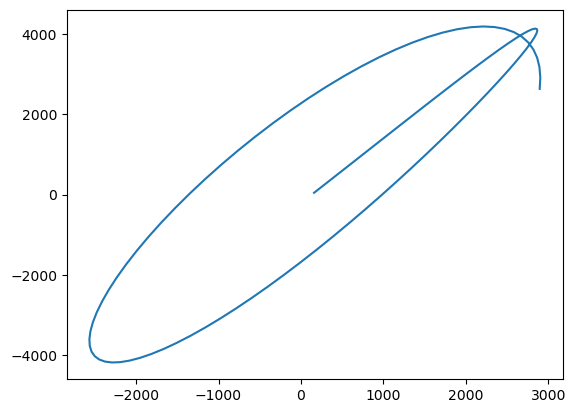

In [133]:
plt.plot(r_store[1],r_store[2])

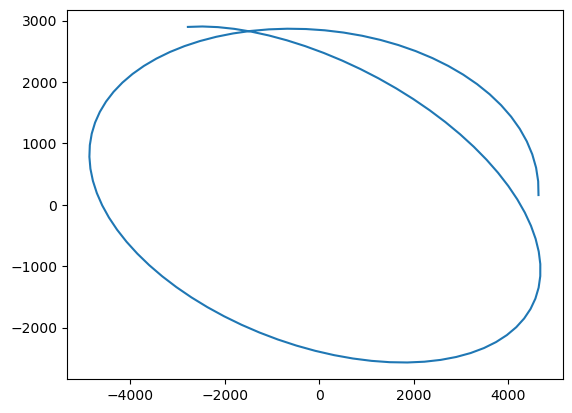

In [134]:
plt.plot(r_store[0],r_store[1])

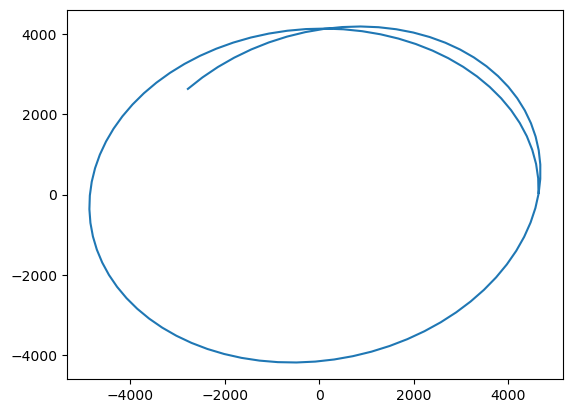

In [135]:
plt.plot(r_store[0],r_store[2])